In [1]:
import pandas as pd
commodity = 'corn'
import utils
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import dataloader_cm
import LSTM

In [215]:
def train(commodity="corn", seq_length = 20):
    train_loader = dataloader_cm.get_dataloader(commodity, seq_length, 'train', 10)
    validation_loader = dataloader_cm.get_dataloader(commodity, seq_length, 'val', 100)

    model = LSTM.CommodityLSTM(validation_loader)

    training_losses, validation_losses = model.train(train_loader, validation_loader)

    training_losses = torch.stack(training_losses).detach().numpy()
    validation_losses = torch.stack(validation_losses).detach().numpy()

    plt.figure(figsize = (15,15))
    plt.title('Traning and Validation MSE Loss, LSTM')
    plt.plot(training_losses, label= 'Training Loss')
    plt.plot(validation_losses, label = 'Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('MSE Loss')
    plt.yscale('log')
    plt.legend()
    return model

In [302]:
def validate_model(model, commodity='corn', split='val', seq_length = 20):
    from torch.utils.data import dataset, dataloader, SequentialSampler
    dataset = dataloader_cm.CommoditiesDataSet(commodity, seq_length, split)
    dl = dataloader.DataLoader(
                dataset=dataset,
                batch_size=1,
                sampler=SequentialSampler(dataset),
                num_workers=2,
                pin_memory=torch.cuda.is_available(),
                drop_last=True,
    )

    predictions, val_losses, actuals = model.test(dl)
    predictions = predictions.flatten()
    actuals = np.array(actuals)

    from backtester import backtest_log
    scaled_returns, actual_returns, strategy_predictors = backtest_log(predictions, actuals)
    return scaled_returns, actual_returns, strategy_predictors

In [305]:
from torch.utils.data import dataset, dataloader, SequentialSampler
dataset = dataloader_cm.CommoditiesDataSet('corn', 20, 'val')
dl = dataloader.DataLoader(
            dataset=dataset,
            batch_size=1,
            sampler=SequentialSampler(dataset),
            num_workers=2,
            pin_memory=torch.cuda.is_available(),
            drop_last=True,
)

predictions, val_losses, actuals = model.test(dl)
predictions = predictions.flatten()
actuals = np.array(actuals)

In [369]:
cornmodel = train('corn', seq_length = 20)

TRAINING BATCH LOSS AT STEP 0: 0.002269501332193613
TRAINING BATCH LOSS AT STEP 50: 4.199630348011851e-05
TRAINING BATCH LOSS AT STEP 100: 2.9868115234421566e-05
TRAINING BATCH LOSS AT STEP 150: 0.00010700021084630862
TRAINING BATCH LOSS AT STEP 200: 7.120754162315279e-05
TRAINING BATCH LOSS AT STEP 250: 4.788889054907486e-05
TRAINING BATCH LOSS AT STEP 300: 2.7315280021866783e-05
TRAINING BATCH LOSS AT STEP 350: 1.847857674874831e-05
TRAINING BATCH LOSS AT STEP 400: 3.821449718088843e-05
TRAINING BATCH LOSS AT STEP 450: 0.0001560017408337444
TRAINING BATCH LOSS AT STEP 500: 0.0006021601147949696
TRAINING BATCH LOSS AT STEP 550: 0.0004331281816121191
TRAINING BATCH LOSS AT STEP 600: 0.0006681482191197574
TRAINING BATCH LOSS AT STEP 650: 9.542048064759001e-05
TRAINING BATCH LOSS AT STEP 700: 0.00018387692398391664
TRAINING BATCH LOSS AT STEP 750: 0.0005607411148957908
TRAINING BATCH LOSS AT STEP 800: 0.0004983806284144521
TRAINING BATCH LOSS AT STEP 850: 0.0006072645192034543
TRAINING B

RuntimeError: stack expects a non-empty TensorList

/Users/bodhinguyen/.pyenv/versions/3.8.5/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 0])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Long only annualized psuedo sharpe:  0.16658119103881772
Strategy annualized psuedo sharpe:  0.5179095773149139
Correlation matrix between strategy predictors and returns
[[1.         0.05043633]
 [0.05043633 1.        ]]
Percent of time predicted direction correctly:  49.740932642487046


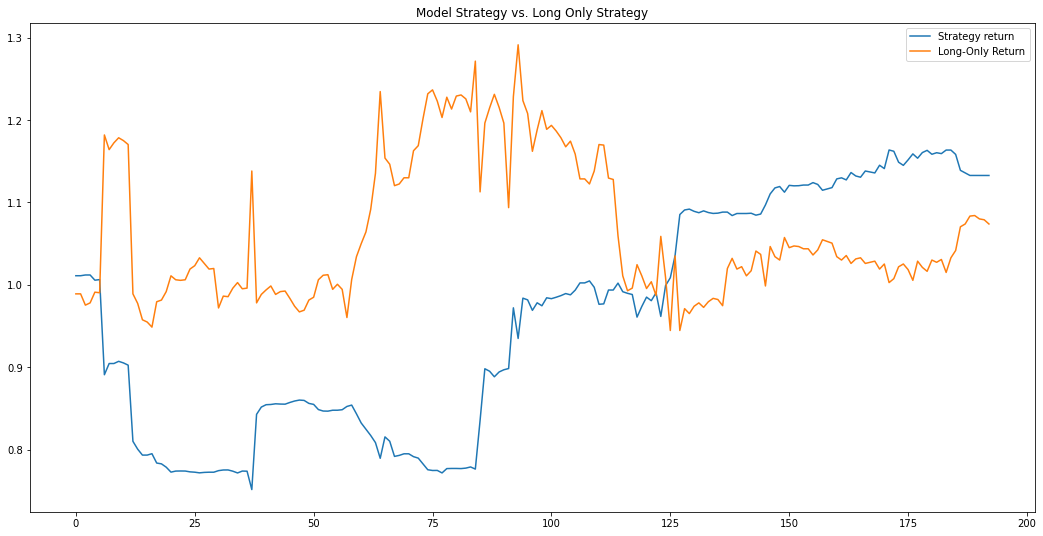

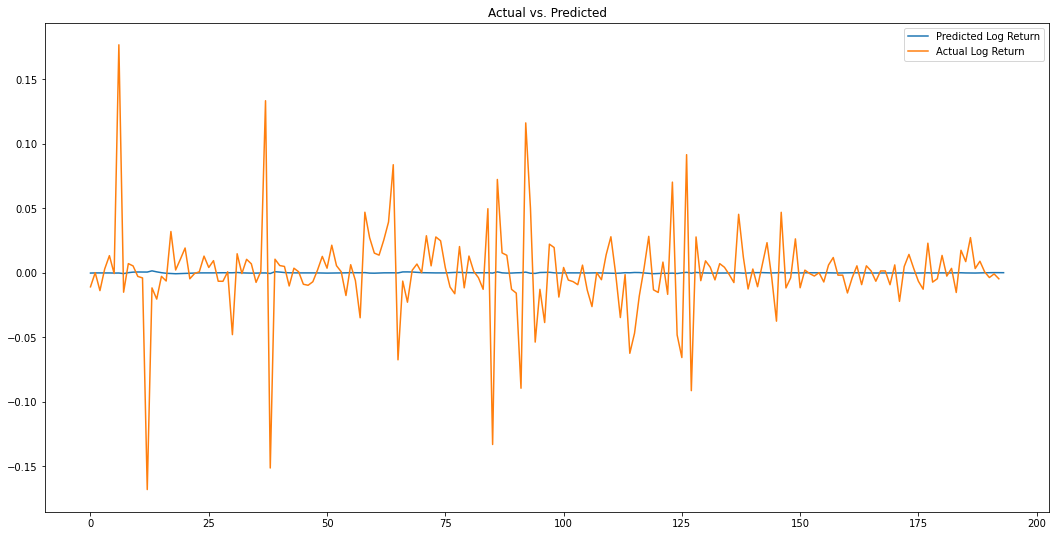

In [371]:
scaled_corn_returns, actual_corn_returns, corn_predictors = validate_model(cornmodel, seq_length = 20, split = 'test')

In [373]:
#evaluation
import statsmodels.api as sm

results = sm.OLS(actual_corn_returns, sm.add_constant(corn_predictors)).fit(cov_type='HAC',cov_kwds={'maxlags': 1})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2800
Date:                Sat, 27 Nov 2021   Prob (F-statistic):              0.597
Time:                        22:43:26   Log-Likelihood:                 372.48
No. Observations:                 193   AIC:                            -741.0
Df Residuals:                     191   BIC:                            -734.4
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.003      0.440      0.660      -0.005       0.008
x1             0.0043      0.008      0.529      0.597      -0.012       0.020
==============================================================================
Omnibus:                       45.441   Durbin-Watson:                   2.431
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              681.803
Skew:                          -0.207   Prob(JB):                    8.88e-149
Kurtosis:                      12.199   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

TRAINING BATCH LOSS AT STEP 0: 0.5873815417289734
VALIDATION BATCH LOSS AT STEP 0: 0.5978516340255737
TRAINING BATCH LOSS AT STEP 50: 0.44190043210983276
VALIDATION BATCH LOSS AT STEP 50: 0.4444262683391571
TRAINING BATCH LOSS AT STEP 100: 0.3126829266548157
VALIDATION BATCH LOSS AT STEP 100: 0.3121476471424103
TRAINING BATCH LOSS AT STEP 150: 0.20597469806671143
VALIDATION BATCH LOSS AT STEP 150: 0.20445170998573303
TRAINING BATCH LOSS AT STEP 200: 0.12476412206888199
VALIDATION BATCH LOSS AT STEP 200: 0.12667810916900635
TRAINING BATCH LOSS AT STEP 250: 0.07417477667331696
VALIDATION BATCH LOSS AT STEP 250: 0.07387533038854599
TRAINING BATCH LOSS AT STEP 300: 0.038950733840465546
VALIDATION BATCH LOSS AT STEP 300: 0.039931926876306534
TRAINING BATCH LOSS AT STEP 350: 0.01845165714621544
VALIDATION BATCH LOSS AT STEP 350: 0.019661352038383484
TRAINING BATCH LOSS AT STEP 400: 0.007768021430820227
VALIDATION BATCH LOSS AT STEP 400: 0.008782791905105114
TRAINING BATCH LOSS AT STEP 450: 0

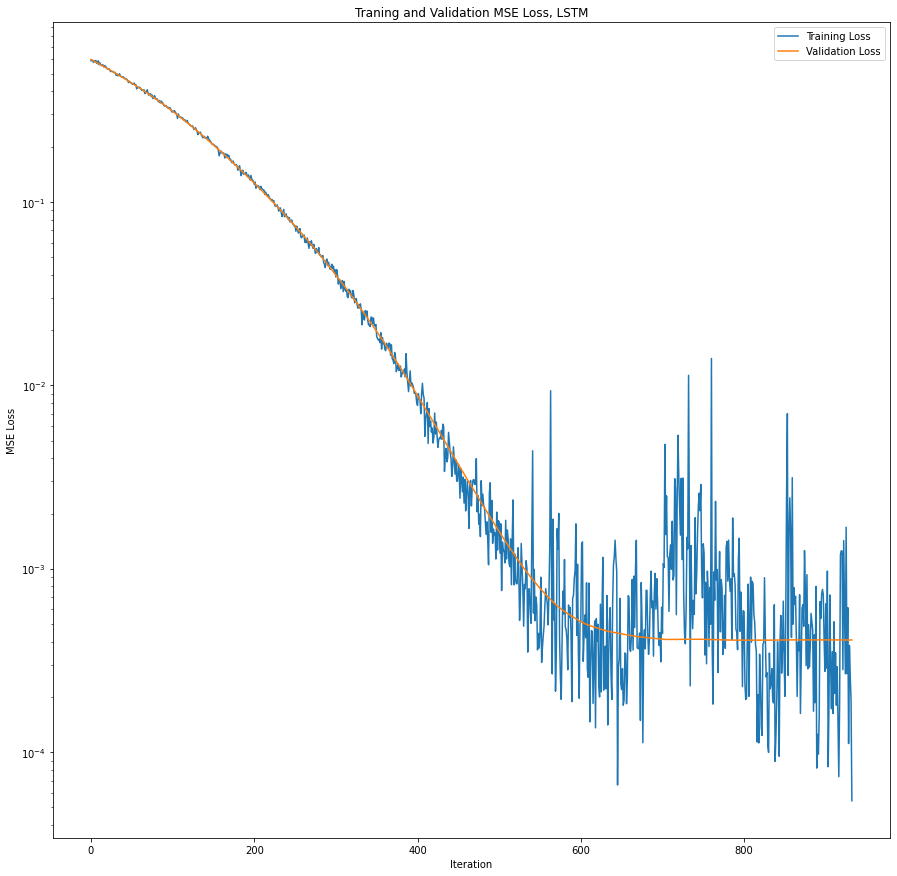

In [353]:
wheatmodel = train('wheat', seq_length = 20)

/Users/bodhinguyen/.pyenv/versions/3.8.5/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 0])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Long only annualized psuedo sharpe:  0.3994782204501277
Strategy annualized psuedo sharpe:  -0.7918444620581444
Correlation matrix between strategy predictors and returns
[[ 1.        -0.0577741]
 [-0.0577741  1.       ]]
Percent of time predicted direction correctly:  44.73684210526316


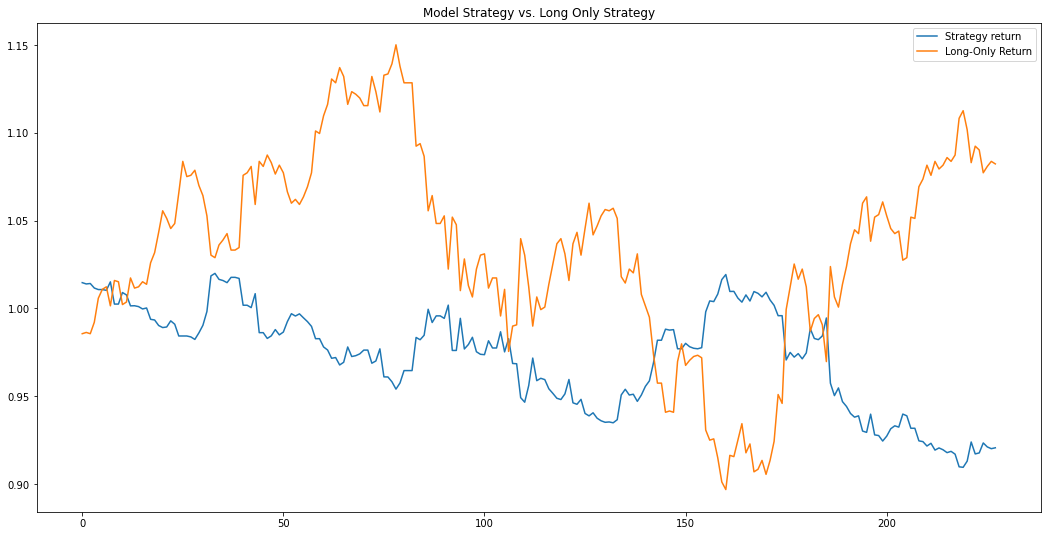

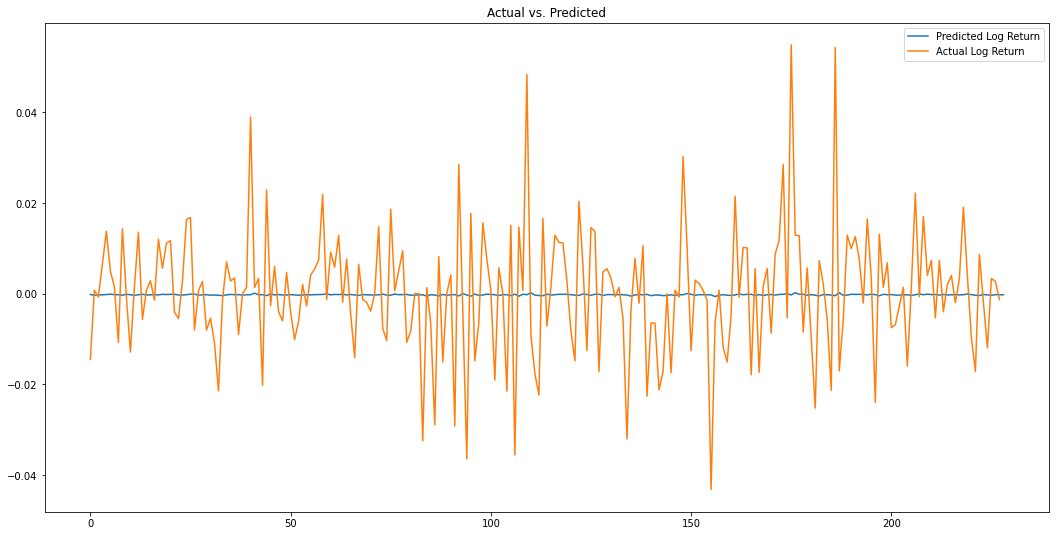

In [359]:
scaled_wheat_returns, actual_wheat_returns, strategy_wheat_predictors = validate_model(wheatmodel, seq_length = 20, split = 'val')

In [348]:
results = sm.OLS(actual_wheat_returns, sm.add_constant(strategy_wheat_predictors)).fit(cov_type='HAC',cov_kwds={'maxlags': 1})
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.5291
Date:                Sat, 27 Nov 2021   Prob (F-statistic):              0.468
Time:                        20:16:49   Log-Likelihood:                 653.61
No. Observations:                 228   AIC:                            -1303.
Df Residuals:                     226   BIC:                            -1296.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.001     -0.295      0.768      -0.003       0.002
x1             0.0016      0.002      0.727      0.467      -0.003       0.006
==============================================================================
Omnibus:                       20.621   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.187
Skew:                           0.314   Prob(JB):                     3.82e-13
Kurtosis:                       5.372   Cond. No.                         3.43
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

In [350]:
strategy_wheat_predictors

[1.0,
 1.0,
 0.5021206140518188,
 0.5975462198257446,
 0.23371705412864685,
 -0.0,
 0.19052352011203766,
 0.3064335882663727,
 0.8360243439674377,
 -0.017884865403175354,
 0.48615166544914246,
 0.9860585331916809,
 0.6014717817306519,
 0.11463703215122223,
 0.7056449055671692,
 0.5153077244758606,
 0.45159289240837097,
 0.5978078842163086,
 0.08743712306022644,
 0.21995902061462402,
 -0.0,
 -0.0,
 0.4941868782043457,
 0.6566803455352783,
 0.493169903755188,
 -0.020339176058769226,
 -0.0,
 0.6437325477600098,
 0.5090599060058594,
 0.5126165747642517,
 0.8539844751358032,
 0.8673219680786133,
 1.0,
 1.0,
 0.6969716548919678,
 0.4932534694671631,
 0.4823729991912842,
 0.41525816917419434,
 0.6368184089660645,
 0.5023975372314453,
 0.4719385802745819,
 -0.0,
 0.4088783264160156,
 0.38453730940818787,
 0.7827558517456055,
 -0.24154894053936005,
 0.5576074719429016,
 0.4374493956565857,
 0.5874234437942505,
 0.6522884368896484,
 0.5276585817337036,
 0.6452423930168152,
 0.7550065517425537,
 